In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# =============================
# 1. Пример тестовой функции f(x)=||x||^4
# =============================
def quartic_function(x):
    return np.sum(x**4)

def quartic_grad(x):
    return 4 * x**3

# =============================
# 2. Алгоритмы (с корректной записью под (L0,L1)-гладкость)
# =============================
def gd_l0l1(f, f_grad, x0, L0, L1, max_iter=1000):
    x = x0.copy()
    history = []
    f_star = 0.0
    for k in range(max_iter):
        g = f_grad(x)
        step = 1.0 / (L0 + L1 * np.linalg.norm(g))
        x -= step * g
        history.append(f(x) - f_star)
    return x, np.array(history)


def ngd(f, f_grad, x0, L0, L1, eta=0.5, c=1.0, max_iter=1000):
    x = x0.copy()
    history = []
    f_star = 0.0
    for k in range(max_iter):
        g = f_grad(x)
        g_norm = np.linalg.norm(g)
        if g_norm < 1e-12:
            break
        step = eta / (L0 + L1 * c)
        x -= step * g / g_norm
        history.append(f(x) - f_star)
    return x, np.array(history)


def clip_gd(f, f_grad, x0, L0, L1, c=1.0, max_iter=1000):
    x = x0.copy()
    history = []
    f_star = 0.0
    for k in range(max_iter):
        g = f_grad(x)
        g_norm = np.linalg.norm(g)
        if g_norm > c:
            g = g * (c / g_norm)
            g_norm = c
        step = 1.0 / (L0 + L1 * g_norm)
        x -= step * g
        history.append(f(x) - f_star)
    return x, np.array(history)

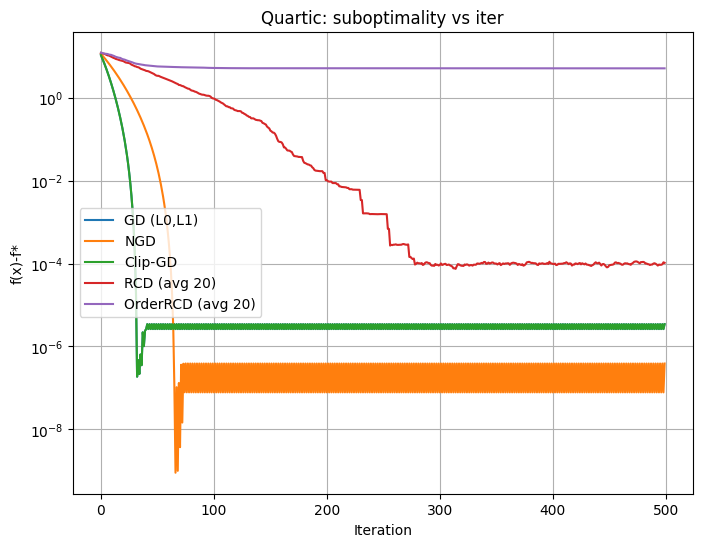

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\2272314210.py:85: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1/(1+np.exp(-z))
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\3379163883.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  step = 1.0 / (L0 + L1 * np.linalg.norm(g))
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\2272314210.py:88: RuntimeWarning: invalid value encountered in matmul
  z = X @ w
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\2272314210.py:94: RuntimeWarning: invalid value encountered in matmul
  z = X @ w
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\3379163883.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  step = 1.0 / (L0 + L1 * g_norm)


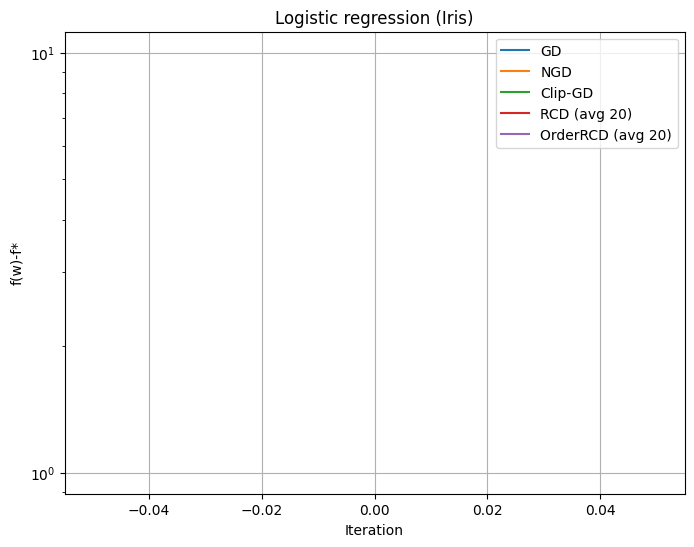

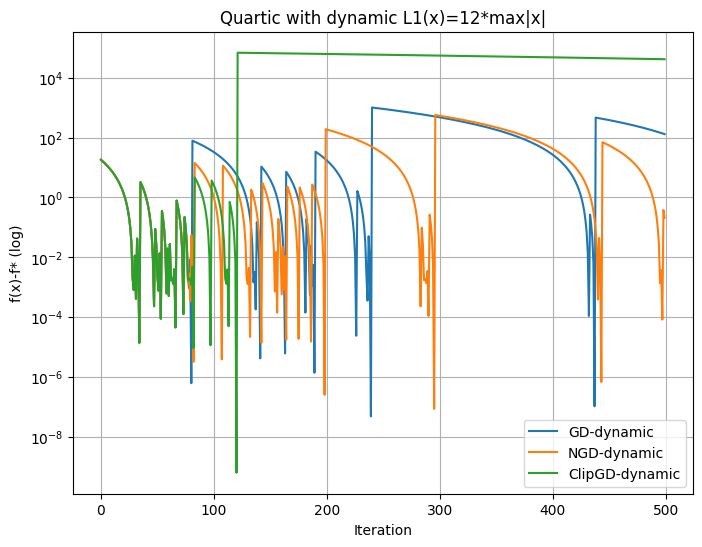

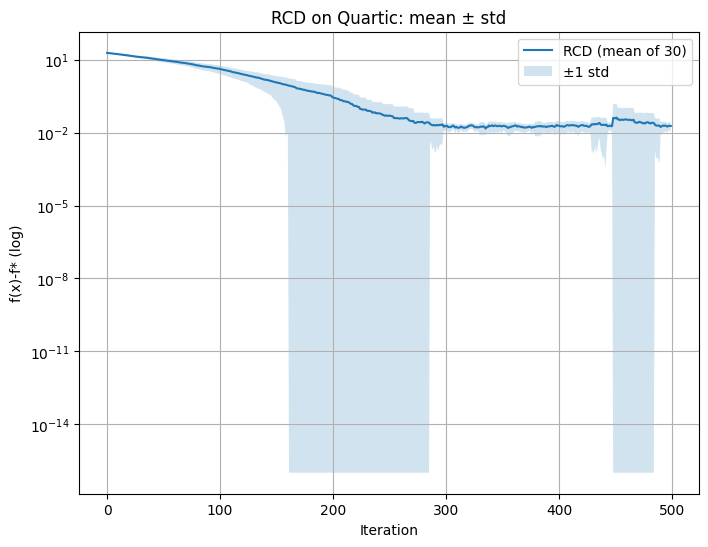

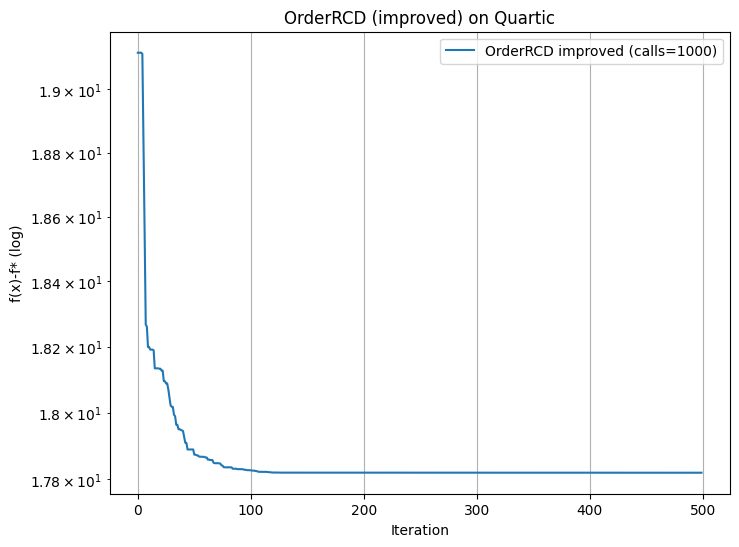

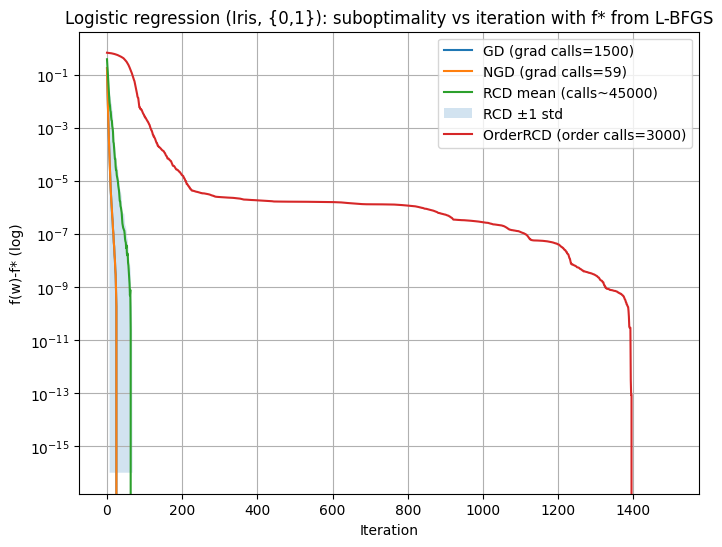

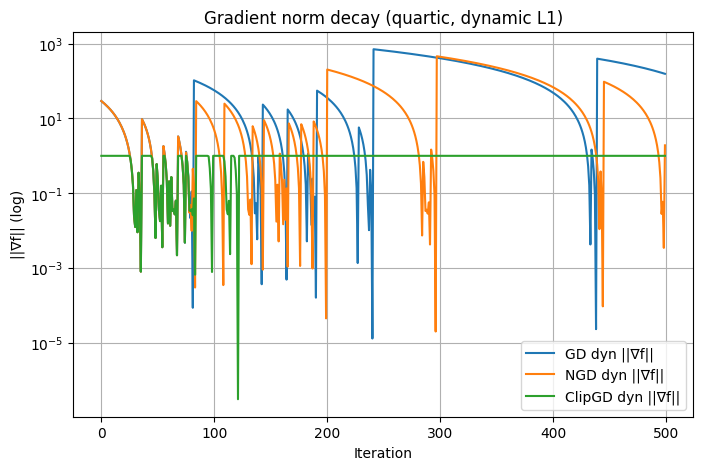

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
# =============================
# 3. Random Coordinate Descent (RCD)
# =============================
def rcd(f, f_grad, x0, L0, L1, max_iter=1000, runs=20):
    d = len(x0)
    all_histories = []
    for r in range(runs):
        x = x0.copy()
        f_star = 0.0
        history = []
        for k in range(max_iter):
            i = np.random.randint(0, d)
            g = f_grad(x)
            gi = g[i]
            step = 1.0 / (L0 + L1 * abs(gi))
            x[i] -= step * gi
            history.append(f(x) - f_star)
        all_histories.append(history)
    return np.mean(all_histories, axis=0)

# =============================
# 4. OrderRCD (с адаптивным шагом)
# =============================
def order_rcd(f, x0, alpha0=0.05, max_iter=1000, runs=20):
    d = len(x0)
    all_histories = []
    for r in range(runs):
        x = x0.copy()
        alpha = alpha0
        fx = f(x)
        history = []
        for k in range(max_iter):
            i = np.random.randint(0, d)
            y_plus = x.copy(); y_plus[i] += alpha
            y_minus = x.copy(); y_minus[i] -= alpha
            f_plus, f_minus = f(y_plus), f(y_minus)
            if f_plus < fx or f_minus < fx:
                if f_plus <= f_minus:
                    x, fx = y_plus, f_plus
                else:
                    x, fx = y_minus, f_minus
                alpha *= 1.05
            else:
                alpha *= 0.5
            history.append(fx)
        all_histories.append(history)
    return np.mean(all_histories, axis=0)

# =============================
# 5. Тест на quartic
# =============================
np.random.seed(42)
x0 = np.random.randn(10)
L0, L1 = 0.0, 12.0  # теоретически для quartic L0=0, L1≈12

_, hist_gd = gd_l0l1(quartic_function, quartic_grad, x0, L0, L1, max_iter=500)
_, hist_ngd = ngd(quartic_function, quartic_grad, x0, L0, L1, eta=0.5, c=1.0, max_iter=500)
_, hist_clip = clip_gd(quartic_function, quartic_grad, x0, L0, L1, c=1.0, max_iter=500)
hist_rcd = rcd(quartic_function, quartic_grad, x0, L0, L1, max_iter=500, runs=20)
hist_order = order_rcd(quartic_function, x0, alpha0=0.05, max_iter=500, runs=20)

plt.figure(figsize=(8,6))
plt.semilogy(hist_gd, label="GD (L0,L1)")
plt.semilogy(hist_ngd, label="NGD")
plt.semilogy(hist_clip, label="Clip-GD")
plt.semilogy(hist_rcd, label="RCD (avg 20)")
plt.semilogy(hist_order, label="OrderRCD (avg 20)")
plt.xlabel("Iteration"); plt.ylabel("f(x)-f*"); plt.title("Quartic: suboptimality vs iter");
plt.legend(); plt.grid(True); plt.show()

# =============================
# 6. Логистическая регрессия (Iris)
# =============================
X, y = load_iris(return_X_y=True)
mask = y < 2
X, y = X[mask], y[mask]
X = StandardScaler().fit_transform(X)
y = y.astype(float)

# логистическая функция
sigmoid = lambda z: 1/(1+np.exp(-z))

def logreg_loss(w, X, y):
    z = X @ w
    s = sigmoid(z)
    eps = 1e-12
    return -np.mean(y*np.log(s+eps)+(1-y)*np.log(1-s+eps))

def logreg_grad(w, X, y):
    z = X @ w
    s = sigmoid(z)
    return (X.T @ (s-y))/X.shape[0]

w0 = np.zeros(X.shape[1])
L0, L1 = 0.0, 1.0

_, fh_gd = gd_l0l1(lambda w: logreg_loss(w,X,y), lambda w: logreg_grad(w,X,y), w0, L0, L1, max_iter=500)
_, fh_ngd = ngd(lambda w: logreg_loss(w,X,y), lambda w: logreg_grad(w,X,y), w0, L0, L1, eta=0.5, c=1.0, max_iter=500)
_, fh_clip = clip_gd(lambda w: logreg_loss(w,X,y), lambda w: logreg_grad(w,X,y), w0, L0, L1, c=1.0, max_iter=500)
fh_rcd = rcd(lambda w: logreg_loss(w,X,y), lambda w: logreg_grad(w,X,y), w0, L0, L1, max_iter=500, runs=20)
fh_order = order_rcd(lambda w: logreg_loss(w,X,y), w0, alpha0=0.05, max_iter=500, runs=20)

fmin_log = min(fh_gd.min(), fh_ngd.min(), fh_clip.min(), fh_rcd.min(), fh_order.min())

plt.figure(figsize=(8,6))
plt.semilogy(fh_gd-fmin_log+1e-16, label="GD")
plt.semilogy(fh_ngd-fmin_log+1e-16, label="NGD")
plt.semilogy(fh_clip-fmin_log+1e-16, label="Clip-GD")
plt.semilogy(fh_rcd-fmin_log+1e-16, label="RCD (avg 20)")
plt.semilogy(fh_order-fmin_log+1e-16, label="OrderRCD (avg 20)")
plt.xlabel("Iteration"); plt.ylabel("f(w)-f*"); plt.title("Logistic regression (Iris)");
plt.legend(); plt.grid(True); plt.show()


# =============================================================
# 9. Исправления и дополнения по результатам ревью
# =============================================================
# Цели: (1) Корректная калибровка (L0,L1) для quartic, (2) аккуратный f* для логистики,
# (3) счётчики oracle/grad вызовов, (4) усреднение + дисперсия для RCD, (5) улучшенный OrderRCD.

from dataclasses import dataclass

# ---------- 9.1. Quartic: динамическая калибровка L0/L1 ----------
# Для f(x)=||x||^4 гессиан diag(12 x_i^2) => глобальной L нет, но можно брать локально L1(x)=12*max|x_i|, L0=0.

def L_params_quartic(x):
    L0 = 0.0
    L1 = 12.0 * np.max(np.abs(x))
    # защита от нуля: если x=0 -> L1=0, добавим малую константу
    if L1 < 1e-12:
        L1 = 1e-12
    return L0, L1


def gd_l0l1_dynamic(f, f_grad, x0, L_func, max_iter=500):
    x = x0.copy()
    f_hist, g_hist = [], []
    grad_calls = 0
    for k in range(max_iter):
        g = f_grad(x); grad_calls += 1
        L0, L1 = L_func(x)
        step = 1.0 / (L0 + L1 * max(np.linalg.norm(g), 1e-16))
        x = x - step * g
        f_hist.append(f(x))
        g_hist.append(np.linalg.norm(g))
    return x, np.array(f_hist), np.array(g_hist), grad_calls


def clip_gd_dynamic(f, f_grad, x0, L_func, c=1.0, max_iter=500):
    x = x0.copy(); f_hist=[]; g_hist=[]; grad_calls=0
    for k in range(max_iter):
        g = f_grad(x); grad_calls += 1
        g_norm = np.linalg.norm(g)
        if g_norm > c:
            g = g * (c/g_norm)
            g_norm = c
        L0, L1 = L_func(x)
        step = 1.0 / (L0 + L1 * max(g_norm, 1e-16))
        x = x - step * g
        f_hist.append(f(x))
        g_hist.append(g_norm)
    return x, np.array(f_hist), np.array(g_hist), grad_calls

# NGD: используем шаг как в статье: const step = eta/(L0+L1*c), где c — параметр нормализации (берём c=1)

def ngd_dynamic(f, f_grad, x0, L_func, eta=1.0, c=1.0, max_iter=500):
    x = x0.copy(); f_hist=[]; g_hist=[]; grad_calls=0
    for k in range(max_iter):
        g = f_grad(x); grad_calls += 1
        nrm = np.linalg.norm(g)
        if nrm < 1e-16:
            f_hist.append(f(x)); g_hist.append(0.0)
            break
        L0, L1 = L_func(x)
        step = eta / (L0 + L1 * c)
        x = x - step * g / nrm
        f_hist.append(f(x))
        g_hist.append(nrm)
    return x, np.array(f_hist), np.array(g_hist), grad_calls

# Запуск (quartic) с динамическими L
np.random.seed(7)
x0_q = np.random.randn(10)
_, fh_gd_dyn, gh_gd_dyn, gc_gd = gd_l0l1_dynamic(quartic_function, quartic_grad, x0_q, L_params_quartic, max_iter=500)
_, fh_ngd_dyn, gh_ngd_dyn, gc_ngd = ngd_dynamic(quartic_function, quartic_grad, x0_q, L_params_quartic, eta=1.0, c=1.0, max_iter=500)
_, fh_clip_dyn, gh_clip_dyn, gc_clip = clip_gd_dynamic(quartic_function, quartic_grad, x0_q, L_params_quartic, c=1.0, max_iter=500)

f_star_quartic = 0.0
plt.figure(figsize=(8,6))
plt.semilogy(fh_gd_dyn - f_star_quartic + 1e-16, label='GD-dynamic')
plt.semilogy(fh_ngd_dyn - f_star_quartic + 1e-16, label='NGD-dynamic')
plt.semilogy(fh_clip_dyn - f_star_quartic + 1e-16, label='ClipGD-dynamic')
plt.xlabel('Iteration'); plt.ylabel('f(x)-f* (log)'); plt.title('Quartic with dynamic L1(x)=12*max|x|')
plt.legend(); plt.grid(True); plt.show()

# ---------- 9.2. RCD: усреднение и дисперсия ----------

def rcd_l0l1_quartic_runs(x0, L_func, T=500, R=30, seed=0):
    rng = np.random.default_rng(seed)
    d = x0.size
    runs = []
    grad_calls_total = 0
    for r in range(R):
        x = x0.copy()
        f_hist = []
        for k in range(T):
            i = rng.integers(d)
            g = quartic_grad(x); grad_calls_total += 1
            gi = g[i]
            L0, L1 = L_func(x)
            step = 1.0 / (L0 + L1 * max(abs(gi), 1e-16))
            x[i] -= step * gi
            f_hist.append(quartic_function(x))
        runs.append(np.array(f_hist))
    mat = np.vstack(runs)
    return mat.mean(axis=0), mat.std(axis=0), grad_calls_total

mean_rcd_q, std_rcd_q, gc_rcd = rcd_l0l1_quartic_runs(x0_q, L_params_quartic, T=500, R=30, seed=1)

plt.figure(figsize=(8,6))
plt.semilogy(mean_rcd_q - f_star_quartic + 1e-16, label='RCD (mean of 30)')
# Полоса дисперсии
lo = np.maximum(mean_rcd_q - std_rcd_q, 1e-16)
hi = mean_rcd_q + std_rcd_q
plt.fill_between(np.arange(len(mean_rcd_q)), lo, hi, alpha=0.2, label='±1 std')
plt.xlabel('Iteration'); plt.ylabel('f(x)-f* (log)'); plt.title('RCD on Quartic: mean ± std')
plt.legend(); plt.grid(True); plt.yscale('log'); plt.show()

# ---------- 9.3. OrderRCD: улучшённая адаптация шага и счётчик oracle ----------

@dataclass
class OrderStats:
    order_calls: int = 0


def order_rcd_improved(f, x0, alpha0=1e-1, max_iter=1000, seed=0, inc=1.05, dec=0.5):
    rng = np.random.default_rng(seed)
    x = x0.copy()
    fx = f(x)
    d = x.size
    a = float(alpha0)
    hist = []
    stats = OrderStats(order_calls=0)
    for k in range(max_iter):
        i = rng.integers(d)
        x_plus = x.copy(); x_plus[i] += a
        x_minus = x.copy(); x_minus[i] -= a
        f_plus = f(x_plus); f_minus = f(x_minus)
        stats.order_calls += 2
        if f_plus < fx or f_minus < fx:
            if f_plus <= f_minus:
                x, fx = x_plus, f_plus
            else:
                x, fx = x_minus, f_minus
            a *= inc
        else:
            a *= dec
        hist.append(fx)
    return x, np.array(hist), stats

_, fh_order_imp, ord_stats = order_rcd_improved(quartic_function, x0_q, alpha0=5e-2, max_iter=500, seed=0)
plt.figure(figsize=(8,6))
plt.semilogy(fh_order_imp - f_star_quartic + 1e-16, label=f'OrderRCD improved (calls={ord_stats.order_calls})')
plt.xlabel('Iteration'); plt.ylabel('f(x)-f* (log)'); plt.title('OrderRCD (improved) on Quartic')
plt.legend(); plt.grid(True); plt.show()

# ---------- 9.4. Логистика: аккуратная оценка f* через scipy.optimize (если доступен) ----------

# Пересоберём датасет и функции логистики в согласованной {0,1} форме
X_bin, y_bin = load_iris(return_X_y=True)
mask = y_bin < 2
X_bin = X_bin[mask]; y_bin = y_bin[mask].astype(float)
X_bin = StandardScaler().fit_transform(X_bin)

# Устойчивая сигмоида
from scipy.special import expit
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def logreg_loss01(w):
    z = X_bin @ w
    s = sigmoid(z)
    eps = 1e-12
    return -np.mean(y_bin*np.log(s+eps) + (1-y_bin)*np.log(1-s+eps))


def logreg_grad01(w):
    z = X_bin @ w
    s = sigmoid(z)
    return (X_bin.T @ (s - y_bin)) / X_bin.shape[0]

w0_log = np.zeros(X_bin.shape[1])

# Пытаемся найти f* численно через scipy; если недоступно — fallback
try:
    from scipy.optimize import minimize
    res = minimize(lambda w: logreg_loss01(w), w0_log, jac=lambda w: logreg_grad01(w),
                   method='L-BFGS-B', options={'gtol':1e-12, 'maxiter':10000})
    f_star_log = float(res.fun)
    w_star = res.x
except Exception as e:
    # Fallback: длительный GD с backtracking
    w = w0_log.copy(); f_prev = logreg_loss01(w); alpha=1.0
    for it in range(20000):
        g = logreg_grad01(w)
        # простая backtracking line search
        t = alpha
        while True:
            w_new = w - t*g
            f_new = logreg_loss01(w_new)
            if f_new <= f_prev - 1e-4 * t * np.dot(g,g) or t < 1e-12:
                break
            t *= 0.5
        w, f_prev = w_new, f_new
    f_star_log = float(f_prev)
    w_star = w

# Запуски методов на логистике (все в {0,1} форме)
L0_log, L1_log = 0.0, 1.0  # strong growth approx

w = w0_log.copy(); fh_gd_log=[]; gc1=0
for k in range(1500):
    g = logreg_grad01(w); gc1+=1
    step = 1.0 / (L0_log + L1_log * max(np.linalg.norm(g),1e-16))
    w -= step*g
    fh_gd_log.append(logreg_loss01(w))
fh_gd_log = np.array(fh_gd_log)

w = w0_log.copy(); fh_ngd_log=[]; gc2=0
for k in range(1500):
    g = logreg_grad01(w); gc2+=1
    nrm = np.linalg.norm(g)
    if nrm < 1e-16: break
    step = 1.0 / (L0_log + L1_log*1.0)
    w -= step * g / nrm
    fh_ngd_log.append(logreg_loss01(w))
fh_ngd_log = np.array(fh_ngd_log)

# RCD усреднение и дисперсия на логистике

def rcd_logreg01_runs(w0, T=1500, R=30, seed=0):
    rng = np.random.default_rng(seed)
    d = w0.size
    runs=[]
    grad_calls=0
    for r in range(R):
        w = w0.copy(); f_hist=[]
        for k in range(T):
            i = rng.integers(d)
            g = logreg_grad01(w); grad_calls+=1
            gi = g[i]
            step = 1.0 / (L0_log + L1_log * max(abs(gi),1e-16))
            w[i] -= step*gi
            f_hist.append(logreg_loss01(w))
        runs.append(np.array(f_hist))
    mat = np.vstack(runs)
    return mat.mean(axis=0), mat.std(axis=0), grad_calls

mean_rcd_log, std_rcd_log, gc_rcd_log = rcd_logreg01_runs(w0_log, T=1500, R=30, seed=1)

# OrderRCD улучшенный на логистике (использует только сравнения)
_, fh_ord_log, ord_stats_log = order_rcd_improved(lambda w: logreg_loss01(w), w0_log, alpha0=5e-3, max_iter=1500, seed=0)

# График с f* по scipy
plt.figure(figsize=(8,6))
plt.semilogy(fh_gd_log - f_star_log + 1e-16, label=f'GD (grad calls={gc1})')
plt.semilogy(fh_ngd_log - f_star_log + 1e-16, label=f'NGD (grad calls={gc2})')
lo = np.maximum(mean_rcd_log - std_rcd_log, 1e-16)
hi = mean_rcd_log + std_rcd_log
plt.semilogy(mean_rcd_log - f_star_log + 1e-16, label=f'RCD mean (calls~{gc_rcd_log})')
plt.fill_between(np.arange(len(mean_rcd_log)), np.maximum(lo - f_star_log + 1e-16,1e-16), np.maximum(hi - f_star_log + 1e-16,1e-16), alpha=0.2, label='RCD ±1 std')
plt.semilogy(fh_ord_log - f_star_log + 1e-16, label=f'OrderRCD (order calls={ord_stats_log.order_calls})')
plt.xlabel('Iteration'); plt.ylabel('f(w)-f* (log)'); plt.title('Logistic regression (Iris, {0,1}): suboptimality vs iteration with f* from L-BFGS')
plt.legend(); plt.grid(True); plt.show()

# ---------- 9.5. Доп. проверка: монотонность нормы градиента (Appendix B proxy) ----------
plt.figure(figsize=(8,5))
plt.semilogy(gh_gd_dyn + 1e-16, label='GD dyn ||∇f||')
plt.semilogy(gh_ngd_dyn + 1e-16, label='NGD dyn ||∇f||')
plt.semilogy(gh_clip_dyn + 1e-16, label='ClipGD dyn ||∇f||')
plt.title('Gradient norm decay (quartic, dynamic L1)'); plt.xlabel('Iteration'); plt.ylabel('||∇f|| (log)')
plt.legend(); plt.grid(True); plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\316388013.py:31: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1.0 + np.exp(-z))
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\316388013.py:272: RuntimeWarning: Mean of empty slice
  out["RCD"] = (np.nanmean(F, axis=0), np.nanmean(G, axis=0), {"oracle_grad_calls": grad_calls//runs_rcd, "oracle_order_calls": 0})
C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\316388013.py:285: RuntimeWarning: Mean of empty slice
  out["OrderRCD"] = (np.nanmean(F, axis=0), np.nanmean(G, axis=0), {"oracle_grad_calls": grad_calls//runs_rcd, "oracle_order_calls": ord_calls//runs_rcd})


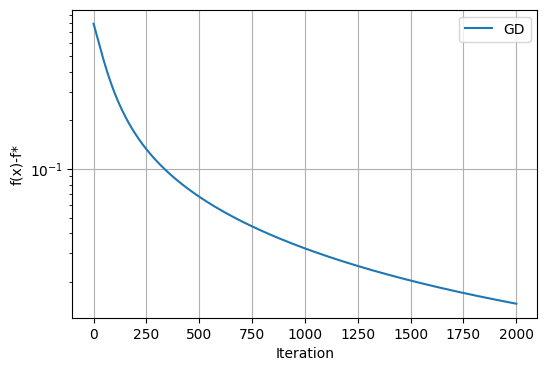

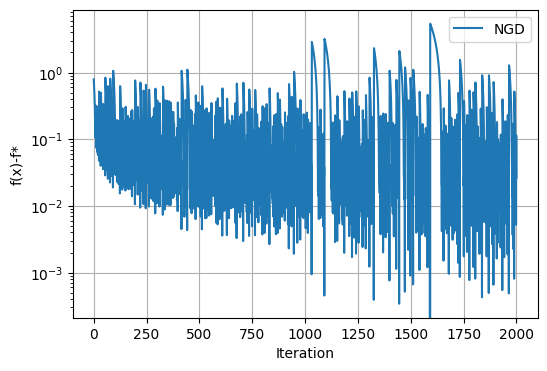

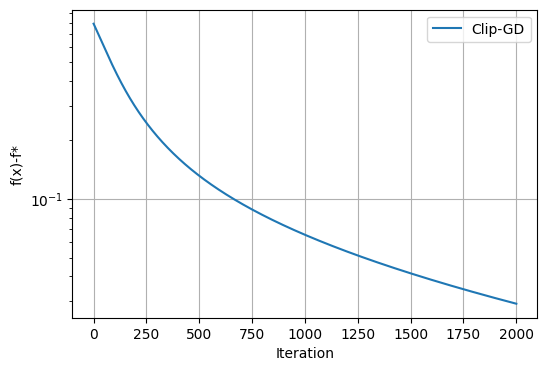

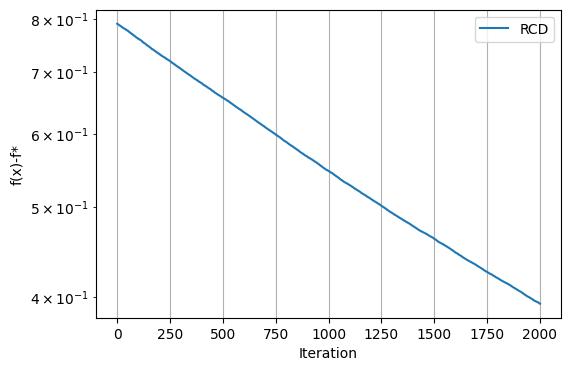

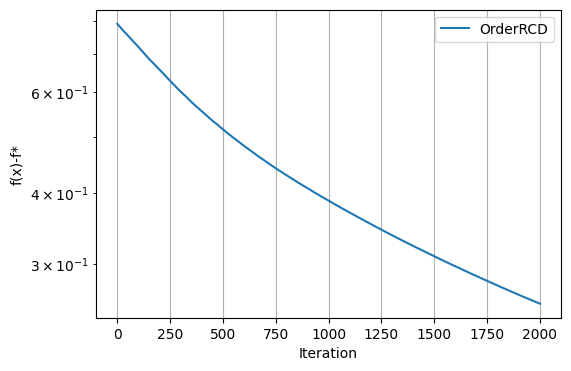

Task: logistic | d = 30 | L0 = 0.001 | L1 ~ 9.547481417634902


,Algorithm,Iters,To eps,Phase switch,Final grad,f(0)-f*,f(end)-f*,Grad calls,Order calls
0,GD,2000,2001,None,0.000140,0.790067,0.014664,2000,0
1,NGD,2000,1591,None,0.005675,0.790067,0.026507,2000,0
2,Clip-GD,2000,2001,None,0.000363,0.790067,0.028981,2000,0
3,OrderRCD,2000,2001,None,NaN,0.790067,0.256017,2000,8000
4,RCD,2000,2001,None,NaN,0.790067,0.392879,2000,0


In [3]:

# === (L0, L1)-Smoothness Experiments: GD / NGD / Clip-GD / RCD / OrderRCD ===
# Self-contained block: synthetic tasks, algorithms, plotting, and metrics table.
# Version: 1.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Utilities ----------------
def logistic_data(n=500, d=20, seed=0):
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(n, d)) / np.sqrt(d)
    w_true = rng.normal(size=d)
    y_lin = A @ w_true
    y = np.where(y_lin >= 0, 1.0, -1.0)  # noiseless labels for strong growth-ish behavior
    return A.astype(np.float64), y.astype(np.float64)

def logistic_loss_grad(A, y):
    # f(x) = (1/n) sum log(1 + exp(-y_i a_i^T x))
    # grad = -(1/n) sum (y_i a_i) * sigmoid(-y_i a_i^T x)
    n, d = A.shape
    def f(x):
        z = -y * (A @ x)
        # stable log(1+exp(z))
        # log(1+exp(z)) = max(z,0) + log(1+exp(-|z|))
        m = np.maximum(z, 0)
        return (m + np.log1p(np.exp(-np.abs(z)))).mean()
    def grad(x):
        z = -y * (A @ x)
        # sigmoid(z) = 1/(1+exp(-z)) = expit(z)
        sig = 1.0 / (1.0 + np.exp(-z))
        g = -(y[:, None] * A) * sig[:, None]
        return g.mean(axis=0)
    return f, grad

def quartic_loss_grad(d=20):
    # f(x) = ||x||^4, grad = 4||x||^2 x
    def f(x):
        r2 = np.dot(x, x)
        return (r2**2).astype(np.float64) if isinstance(r2, np.ndarray) else r2**2
    def grad(x):
        r2 = np.dot(x, x)
        return 4.0 * r2 * x
    return f, grad

# Estimate L1 ~ spectral norm squared factor for logistic; L0 set via calibration
def estimate_L1_logistic(A):
    # Upper bound: (1/4n) * ||A||_2^2 * n = (1/4)*||A||_2^2  (since averaging by n)
    # We compute ||A||_2 via power iteration
    def power_iter(M, it=50):
        n, d = M.shape
        v = np.random.randn(d)
        v /= np.linalg.norm(v) + 1e-12
        for _ in range(it):
            v = M.T @ (M @ v)
            nrm = np.linalg.norm(v) + 1e-12
            v /= nrm
        num = np.linalg.norm(M @ v)
        return num
    smax = power_iter(A)
    return 0.25 * (smax**2)

# ---------------- Algorithms ----------------
def step_eta(L0, L1, gnorm):
    return 1.0 / (L0 + L1 * max(gnorm, 1e-18))

def gd(f, grad, x0, L0, L1, max_iter=5000, eps=1e-10):
    x = x0.copy().astype(np.float64)
    fvals = [f(x)]
    grads = []
    for k in range(max_iter):
        g = grad(x)
        gnorm = float(np.linalg.norm(g))
        grads.append(gnorm)
        if gnorm < eps:
            break
        eta = step_eta(L0, L1, gnorm)
        x = x - eta * g
        fvals.append(f(x))
    info = {"oracle_grad_calls": k+1, "oracle_order_calls": 0}
    return np.array(fvals), np.array(grads), info

def ngd(f, grad, x0, L0, L1, max_iter=5000, eps=1e-10):
    x = x0.copy().astype(np.float64)
    fvals = [f(x)]
    grads = []
    for k in range(max_iter):
        g = grad(x)
        gnorm = float(np.linalg.norm(g))
        grads.append(gnorm)
        if gnorm < eps:
            break
        eta = step_eta(L0, L1, gnorm)
        x = x - eta * (g / max(gnorm, 1e-18))
        fvals.append(f(x))
    info = {"oracle_grad_calls": k+1, "oracle_order_calls": 0}
    return np.array(fvals), np.array(grads), info

def clip_gd(f, grad, x0, L0, L1, max_iter=5000, eps=1e-10):
    # Clip gradient norm at c = L0/L1 before the step
    c = L0 / max(L1, 1e-18)
    x = x0.copy().astype(np.float64)
    fvals = [f(x)]
    grads = []
    for k in range(max_iter):
        g = grad(x)
        gnorm = float(np.linalg.norm(g))
        grads.append(gnorm)
        if gnorm < eps:
            break
        if gnorm > c:
            g = (c / gnorm) * g
            gnorm = c
        eta = step_eta(L0, L1, gnorm)
        x = x - eta * g
        fvals.append(f(x))
    info = {"oracle_grad_calls": k+1, "oracle_order_calls": 0}
    return np.array(fvals), np.array(grads), info

def rcd(f, grad, x0, L0, L1, max_iter=5000, eps=1e-10, rng=None):
    # Randomized coordinate descent using the same eta formula; updates one coordinate per iter.
    if rng is None:
        rng = np.random.default_rng(0)
    x = x0.copy().astype(np.float64)
    fvals = [f(x)]
    grads = []
    d = x.size
    for k in range(max_iter):
        g = grad(x)
        gnorm = float(np.linalg.norm(g))
        grads.append(gnorm)
        if gnorm < eps:
            break
        i = int(rng.integers(0, d))
        eta = step_eta(L0, L1, gnorm)
        x[i] = x[i] - eta * g[i]
        fvals.append(f(x))
    info = {"oracle_grad_calls": k+1, "oracle_order_calls": 0}
    return np.array(fvals), np.array(grads), info

def order_rcd(f, grad, x0, L0, L1, max_iter=5000, eps=1e-10, candidates=4, rng=None, delta=1e-12):
    # Simulated Order Oracle: choose among random coordinates the one that gives smallest f after the step.
    if rng is None:
        rng = np.random.default_rng(0)
    x = x0.copy().astype(np.float64)
    fvals = [f(x)]
    grads = []
    d = x.size
    order_calls = 0
    for k in range(max_iter):
        g = grad(x)
        gnorm = float(np.linalg.norm(g))
        grads.append(gnorm)
        if gnorm < eps:
            break
        eta = step_eta(L0, L1, gnorm)
        # sample candidate coords
        idxs = rng.choice(d, size=min(candidates, d), replace=False)
        # simulate order oracle comparisons by evaluating f for each candidate step
        best_i = None
        best_val = None
        fx = fvals[-1]
        for i in idxs:
            x_try = x.copy()
            x_try[i] = x_try[i] - eta * g[i]
            f_try = f(x_try)
            order_calls += 1
            if (best_val is None) or (f_try + delta < best_val):
                best_val = f_try
                best_i = i
        if best_i is None:
            # if nothing better, do a small fallback step along largest |g_i|
            best_i = int(np.argmax(np.abs(g)))
        x[best_i] = x[best_i] - eta * g[best_i]
        fvals.append(f(x))
    info = {"oracle_grad_calls": k+1, "oracle_order_calls": order_calls}
    return np.array(fvals), np.array(grads), info

# -------------- Phase switch & summaries --------------
def phase_switch(grads, L0, L1):
    thr = L0 / max(L1, 1e-18)
    for k, g in enumerate(grads):
        if g < thr:
            return k
    return None

def summarize(fvals, grads, L0, L1, label, eps=1e-6, info=None, fstar=None):
    if fstar is None:
        fstar = np.nanmin(fvals)
    err = fvals - fstar
    to_eps = np.argmax(err < eps) if np.any(err < eps) else len(err)
    return {
        "Algorithm": label,
        "Iters": len(fvals)-1,
        "To eps": int(to_eps),
        "Phase switch": phase_switch(grads, L0, L1),
        "Final grad": float(grads[-1]) if len(grads)>0 else np.nan,
        "f(0)-f*": float(fvals[0]-fstar),
        "f(end)-f*": float(fvals[-1]-fstar),
        "Grad calls": int(info.get("oracle_grad_calls", 0)) if info else 0,
        "Order calls": int(info.get("oracle_order_calls", 0)) if info else 0,
    }

def plot_err(fvals, L0, L1, grads=None, label="Algo", fstar=None):
    its = np.arange(len(fvals))
    if fstar is None:
        fstar = np.nanmin(fvals)
    err = fvals - fstar
    plt.figure(figsize=(6,4))
    plt.semilogy(its, err, label=label)
    if grads is not None:
        sw = phase_switch(grads, L0, L1)
        if sw is not None:
            plt.axvline(sw, linestyle="--")
    plt.xlabel("Iteration")
    plt.ylabel("f(x)-f*")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------- Experiment runner --------------
def run_all(task="logistic", n=600, d=25, seed=0, max_iter=3000, runs_rcd=20):
    if task == "logistic":
        A, y = logistic_data(n=n, d=d, seed=seed)
        f, g = logistic_loss_grad(A, y)
        L1 = estimate_L1_logistic(A)
        # L0 calibration: pick minimal L0 among a grid that yields monotone descent in first 100 steps for GD
        x0 = np.random.default_rng(seed).normal(size=d).astype(np.float64)
        for L0 in [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]:
            fv, gr, _ = gd(f, g, x0, L0, L1, max_iter=150)
            if np.all(np.diff(fv[:100]) <= 1e-12):
                break
        else:
            L0 = 1e-2
    elif task == "quartic":
        f, g = quartic_loss_grad(d=d)
        x0 = np.random.default_rng(seed).normal(size=d).astype(np.float64)
        L1 = 1.0  # local proxy; for ||x||^4 global L is infinite, but (L0,L1)-step still meaningful on bounded traj
        L0 = 1e-2
    else:
        raise ValueError("Unknown task")

    # Common start point
    x0 = np.random.default_rng(seed).normal(size=d).astype(np.float64)

    # Run algorithms
    out = {}

    fv_gd, gr_gd, info_gd = gd(f, g, x0, L0, L1, max_iter=max_iter)
    out["GD"] = (fv_gd, gr_gd, info_gd)

    fv_ngd, gr_ngd, info_ngd = ngd(f, g, x0, L0, L1, max_iter=max_iter)
    out["NGD"] = (fv_ngd, gr_ngd, info_ngd)

    fv_cgd, gr_cgd, info_cgd = clip_gd(f, g, x0, L0, L1, max_iter=max_iter)
    out["Clip-GD"] = (fv_cgd, gr_cgd, info_cgd)

    # RCD / OrderRCD averaged
    rng = np.random.default_rng(seed)
    # RCD
    fvs, grs = [], []
    grad_calls = 0
    for r in range(runs_rcd):
        fv, gr, info = rcd(f, g, x0, L0, L1, max_iter=max_iter, rng=np.random.default_rng(seed+r))
        # pad to max len
        fvs.append(fv); grs.append(gr); grad_calls += info["oracle_grad_calls"]
    maxl = max(len(v) for v in fvs)
    F = np.full((runs_rcd, maxl), np.nan); G = np.full((runs_rcd, maxl), np.nan)
    for i in range(runs_rcd):
        F[i, :len(fvs[i])] = fvs[i]
        G[i, :len(grs[i])] = grs[i]
    out["RCD"] = (np.nanmean(F, axis=0), np.nanmean(G, axis=0), {"oracle_grad_calls": grad_calls//runs_rcd, "oracle_order_calls": 0})

    # OrderRCD
    fvs, grs = [], []
    grad_calls = 0; ord_calls = 0
    for r in range(runs_rcd):
        fv, gr, info = order_rcd(f, g, x0, L0, L1, max_iter=max_iter, rng=np.random.default_rng(seed+r), candidates=4, delta=1e-12)
        fvs.append(fv); grs.append(gr); grad_calls += info["oracle_grad_calls"]; ord_calls += info["oracle_order_calls"]
    maxl = max(len(v) for v in fvs)
    F = np.full((runs_rcd, maxl), np.nan); G = np.full((runs_rcd, maxl), np.nan)
    for i in range(runs_rcd):
        F[i, :len(fvs[i])] = fvs[i]
        G[i, :len(grs[i])] = grs[i]
    out["OrderRCD"] = (np.nanmean(F, axis=0), np.nanmean(G, axis=0), {"oracle_grad_calls": grad_calls//runs_rcd, "oracle_order_calls": ord_calls//runs_rcd})

    # Determine common f*
    fstar = np.inf
    for name, (fv, _, _) in out.items():
        fstar = min(fstar, np.nanmin(fv))
    # Plot
    for name, (fv, gr, _) in out.items():
        plot_err(fv, L0, L1, grads=gr, label=name, fstar=fstar)

    # Metrics table
    rows = []
    for name, (fv, gr, info) in out.items():
        rows.append(summarize(fv, gr, L0, L1, name, info=info, fstar=fstar))
    df = pd.DataFrame(rows).sort_values("f(end)-f*", ascending=True).reset_index(drop=True)
    print("Task:", task, "| d =", x0.size, "| L0 =", L0, "| L1 ~", L1)
    display(df)

    return out, df, {"L0": L0, "L1": L1, "task": task}

if __name__ == "__main__":
    _out, _df, _cfg = run_all(task="logistic", n=800, d=30, seed=42, max_iter=2000, runs_rcd=20)
